No GPU available, using the CPU instead.


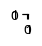

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

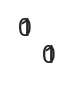

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

3480


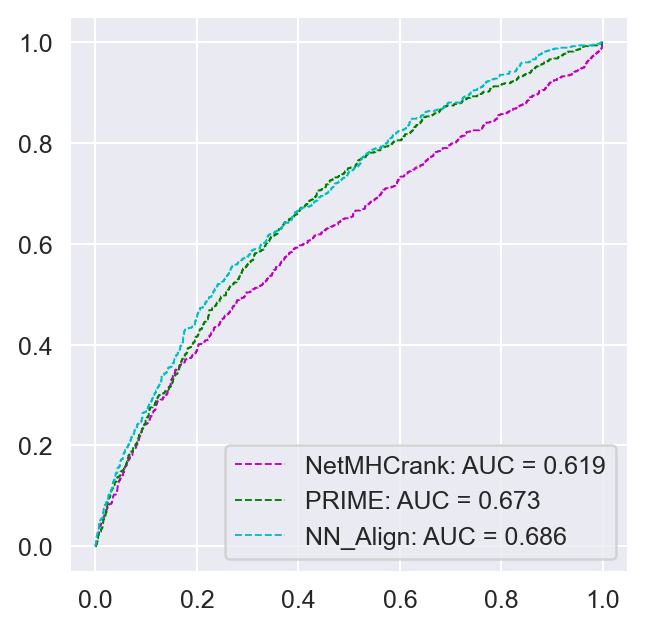

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

In [6]:
from src.baselines import plot_related_baseline_roc

In [12]:
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

(86, 94)

In [ ]:
cedar_related_baseline.query('Peptide not in 

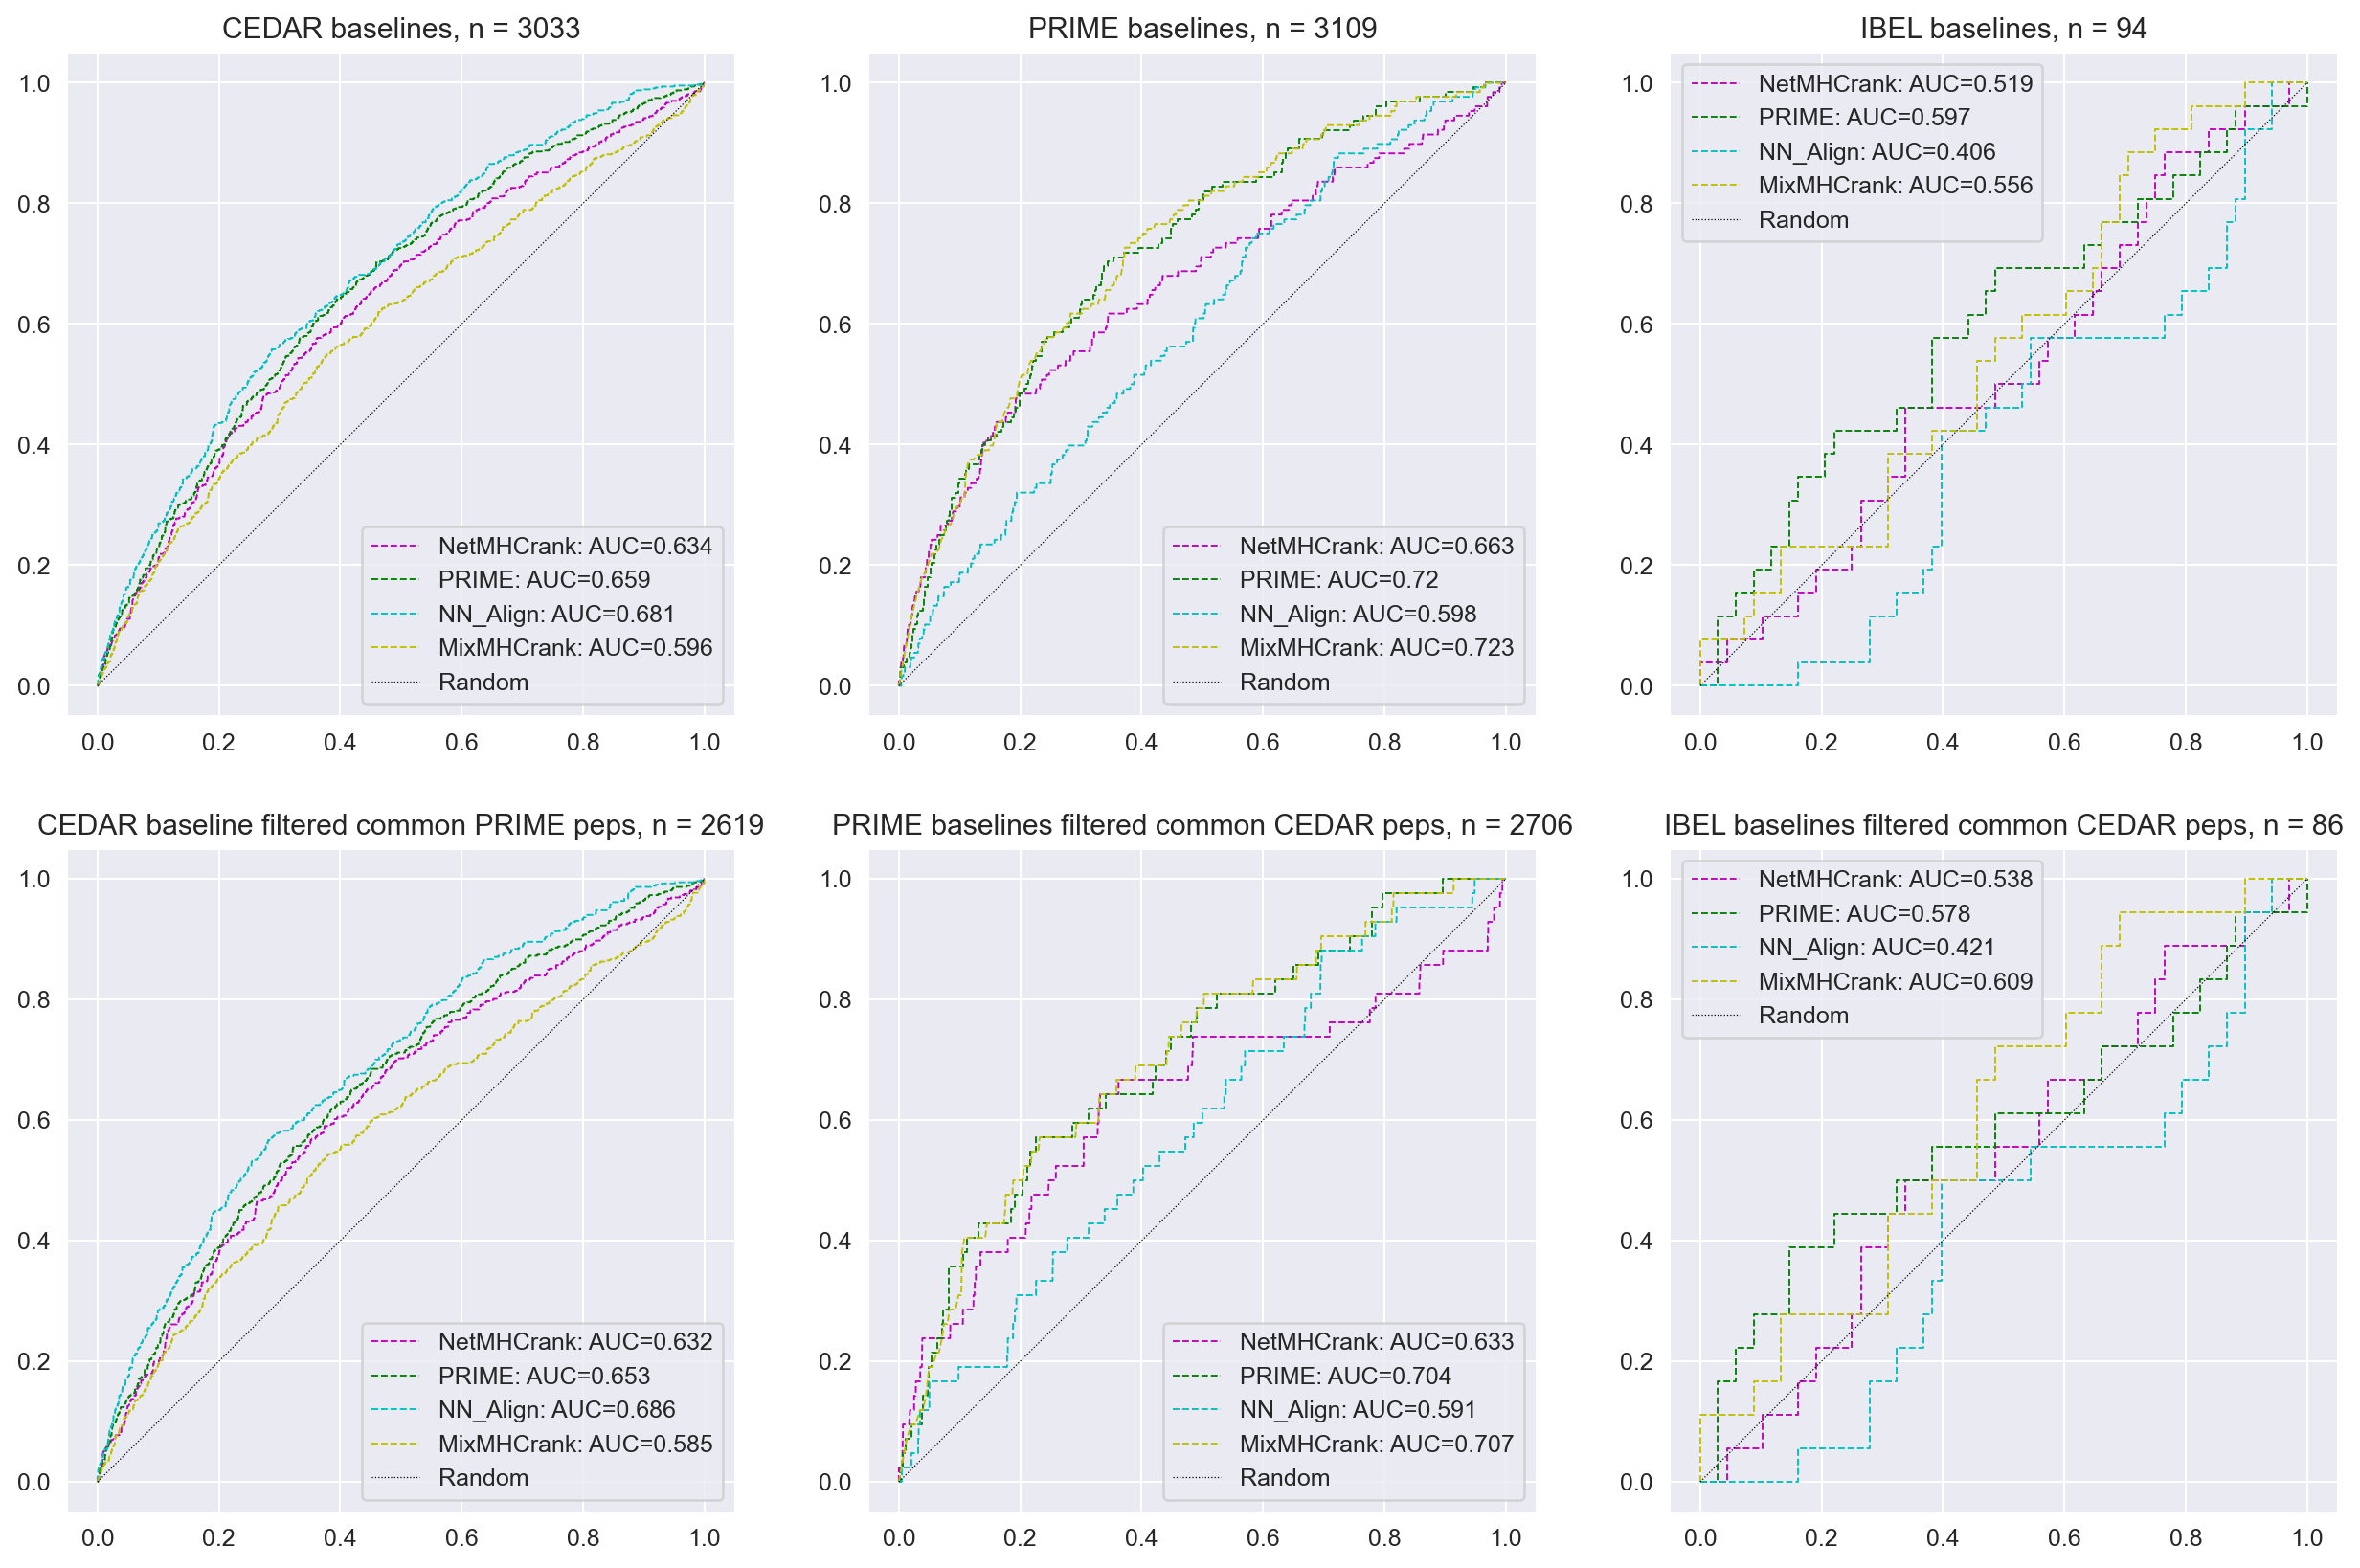

In [51]:
f,a = plt.subplots(2,3, figsize=(17,11))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend()
a[1].legend()
a[2].legend()
a[3].legend()
a[4].legend()
a[5].legend()

In [14]:
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

0.5784313725490196

# Indep eval / benchmarking on raw preds

In [87]:
pdir = '../output/221122_mutscore_cedar_fixed/230116_preds_copy_noRatio_noSwitch/'
fs = sorted(filter(lambda x: 'Peptide_trueHLA' in x or 'icore_mut_EL_rank' in x, os.listdir(pdir)))
ommited = [x for x in ppeps if x not in pd.read_csv(f'{pdir}{fs[-1]}').Peptide.values]
len(fs)

1890

In [89]:
prime_related_baseline.columns

Index(['Peptide', 'HLA', 'nnalign_score', 'MixMHCrank', 'PRIME_score',
       'MixMHCallele', 'trueHLA_EL_rank', 'agg_label', 'core', 'len',
       'wild_type', 'wt_EL_rank', 'mutation_type', 'mutation_position',
       'anchor_mutation', 'mhc_anchor', 'wt_core', 'ratio_rank',
       'core_mutation_position', 'binder', 'StudyOrigin', 'HLA_full', 'seq_id',
       'Pos_mut', 'Peptide_mut', 'core_mut', 'icore_mut', 'EL_rank_mut',
       'Pos_wt', 'Peptide_wt', 'core_wt', 'icore_wt', 'EL_rank_wt',
       'mutation_score', 'blsm_mut_score', 'core_mutation_score',
       'core_blsm_mut_score', 'mut_wt_sim', 'dissimilarity_score'],
      dtype='object')

In [95]:
tmp = prime_related_baseline.query('Peptide in @ommited')
tmp['peptrue'] = tmp['Peptide']==tmp['wild_type']
tmp['coretrue'] = tmp['core_mut'] == tmp['core_wt']
tmp['icoretrue']= tmp['icore_mut']==tmp['icore_wt']
tmp['hla_true'] = tmp['HLA'].apply(lambda x: x in HLAS)
tmp[['peptrue', 'coretrue', 'icoretrue', 'hla_true']]

,peptrue,coretrue,icoretrue,hla_true
48,False,False,False,True
76,False,False,False,True
88,False,False,False,True
89,False,False,False,True
318,False,False,False,True
319,False,False,False,True
1115,False,False,False,True
1116,False,False,False,True
1117,False,False,False,True
1172,False,False,False,True


In [79]:
def get_pred(evalset, encoding, weight, pep_col, rank_col, key):
    fn = f"{evalset.lower()}_preds_{encoding}_{weight.replace(' ','-')}_{pep_col}_{rank_col}_{key}.csv"
    return pd.read_csv(f'{pdir}{fn}')

In [119]:
gb_agg = pd.read_csv('../output/221122_mutscore_cedar_fixed/gb_agg.csv')
gb_agg['mean_auc_agg'] = .5*(gb_agg['mean_auc_CEDAR']+gb_agg['mean_auc_PRIME'])
gb_agg['mean_auc_std'] = gb_agg.apply(lambda x: np.std([x['mean_auc_CEDAR'],x['mean_auc_PRIME']]), axis=1)
gb_agg['agg_selection'] = gb_agg.apply(lambda x: .5*x['mean_auc_CEDAR']+.3 * x['mean_auc_agg'] + .2 * (1-x['mean_auc_std']), axis = 1)
auc_cols = [x for x in gb_agg.columns if 'auc' in x.lower() or x=='agg_selection']
cdt_cols = ['encoding', 'weight', 'pep_col', 'rank_col', 'key']
gb_agg = gb_agg[['encoding', 'weight', 'pep_col', 'rank_col', 'key']+auc_cols]


In [ ]:
gb_agg.sort_values('agg_selection', ascending=False)


In [129]:
best_models = {}
for col in filter(lambda x: x!='mean_auc_agg' and x !='mean_auc_std',auc_cols):
    print(col)
    display(gb_agg.sort_values(col, ascending=False).head(3))
    c = col.replace('mean_auc_', 'Best for ')
    best_models[c] = {}
    best_models[c]['cdt'] = gb_agg.sort_values(col, ascending=False).head(1)[cdt_cols].squeeze().to_dict()

mean_auc_CEDAR


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
481,onehot,Inverted Shannon,icore_mut,EL_rank_mut,aa_props,0.727794,0.642723,0.531257,0.685259,0.042535,0.760968
421,onehot,Inverted KL,icore_mut,EL_rank_mut,aa_props,0.726676,0.641571,0.534083,0.684124,0.042552,0.760065
420,onehot,Inverted KL,Peptide,trueHLA_EL_rank,aa_props,0.722811,0.654043,0.529108,0.688427,0.034384,0.761057


mean_auc_PRIME


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
549,onehot,Mask,icore_mut,EL_rank_mut,core_blsm_mut_score-core_mutation_score,0.706017,0.703309,0.591876,0.704663,0.001354,0.764137
545,onehot,Mask,icore_mut,EL_rank_mut,blsm_mut_score-mutation_score,0.705828,0.699351,0.608903,0.702590,0.003239,0.763043
543,onehot,Mask,icore_mut,EL_rank_mut,blsm_mut_score,0.705893,0.699349,0.611067,0.702621,0.003272,0.763078


mean_auc_IBEL


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
348,BL62LO,Mask,Peptide,trueHLA_EL_rank,dissimilarity_score-core_blsm_mut_score,0.684020,0.676707,0.661289,0.680363,0.003656,0.745388
350,BL62LO,Mask,Peptide,trueHLA_EL_rank,dissimilarity_score-core_blsm_mut_score-core_m...,0.684068,0.676156,0.660834,0.680112,0.003956,0.745276
346,BL62LO,Mask,Peptide,trueHLA_EL_rank,dissimilarity_score-blsm_mut_score-mutation_score,0.684585,0.675190,0.658868,0.679888,0.004697,0.745319


agg_selection


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
525,onehot,KL,icore_mut,EL_rank_mut,dissimilarity_score-blsm_mut_score,0.718283,0.681642,0.607006,0.699962,0.018320,0.765466
615,onehot,Shannon,icore_mut,EL_rank_mut,dissimilarity_score-blsm_mut_score,0.718035,0.679810,0.609920,0.698922,0.019112,0.764872
617,onehot,Shannon,icore_mut,EL_rank_mut,dissimilarity_score-blsm_mut_score-mutation_score,0.718130,0.678767,0.613869,0.698449,0.019682,0.764663


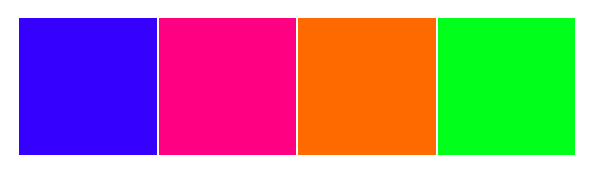

In [106]:
sns.palplot(HSV)

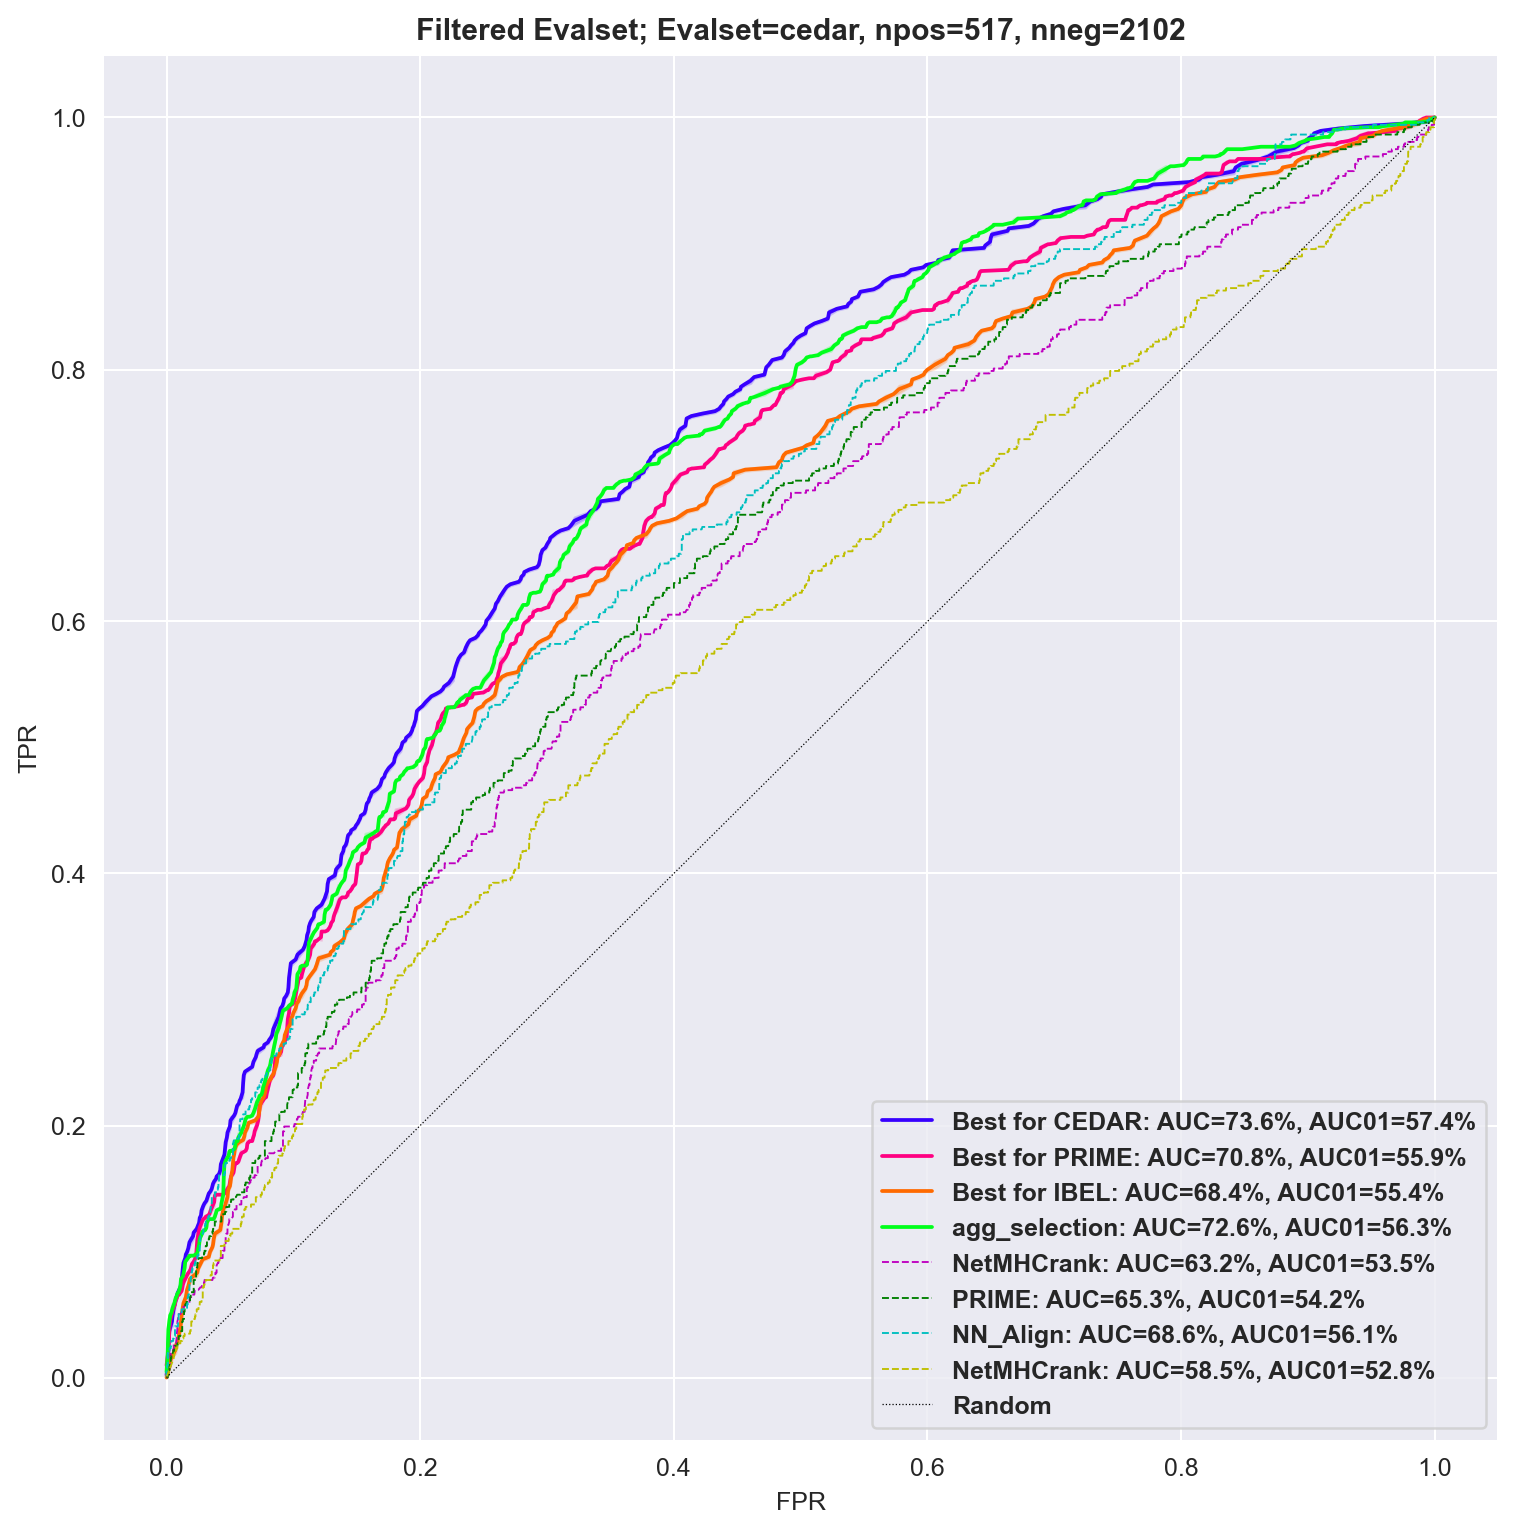

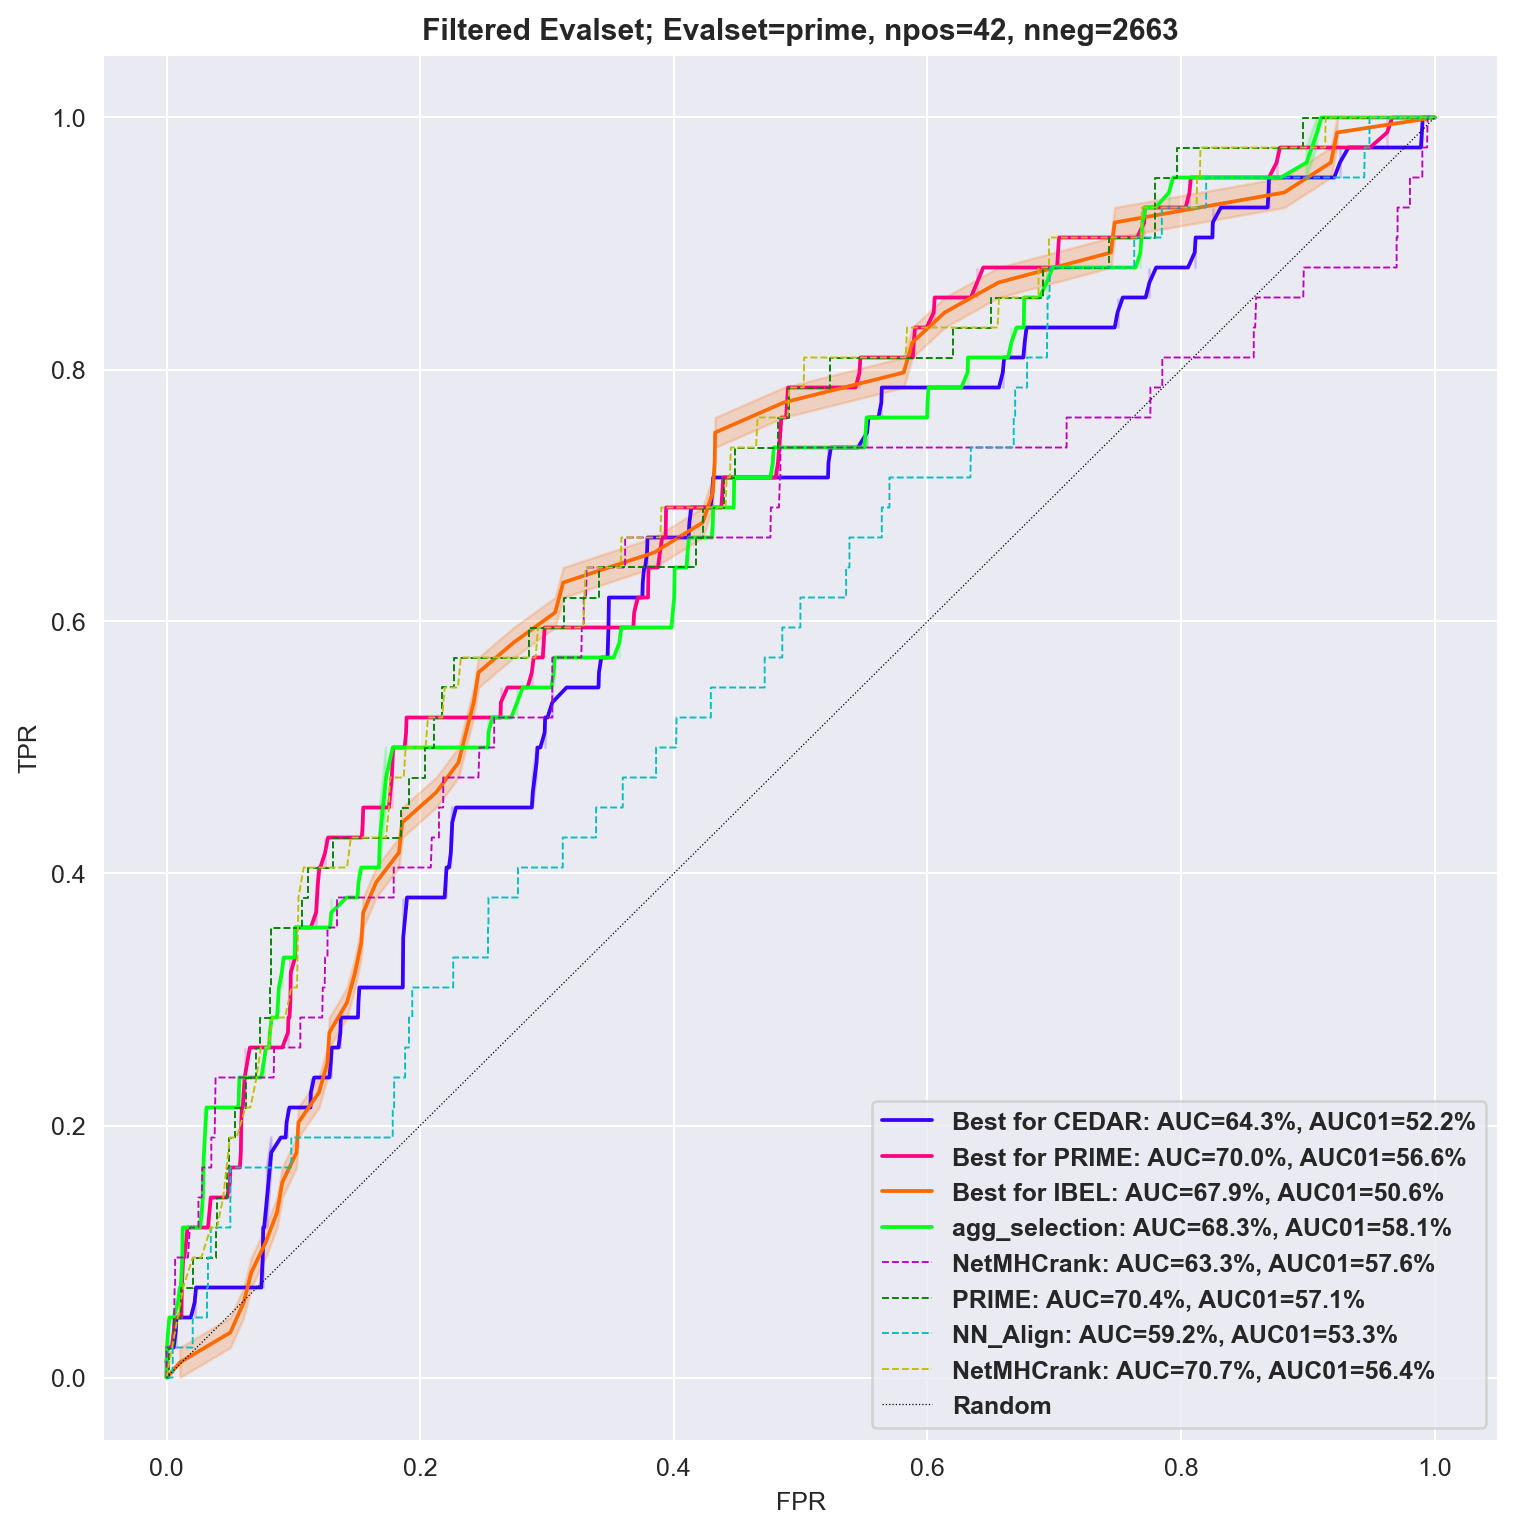

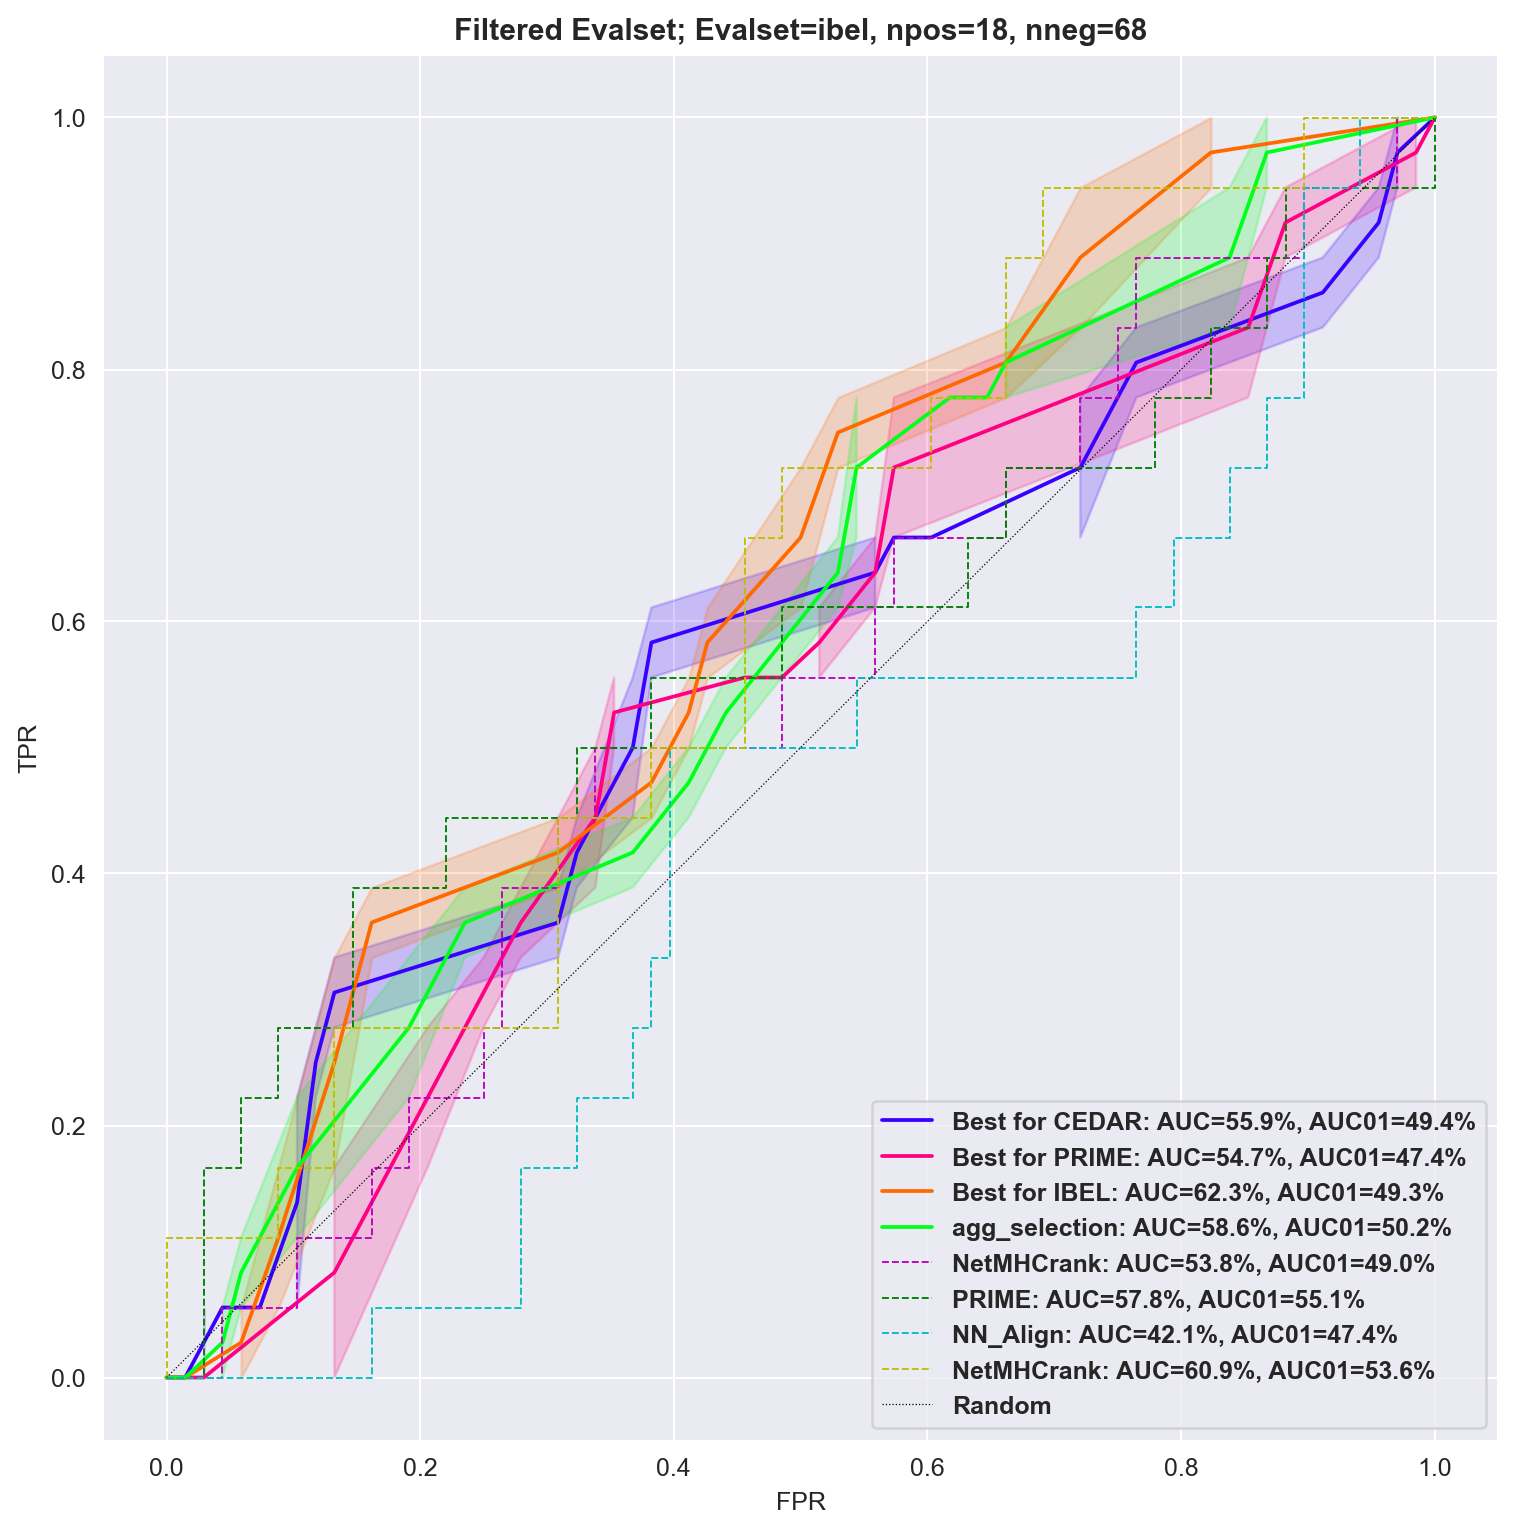

In [143]:
sns.set_palette(HSV)
for evalset,baseline in zip(['cedar', 'prime', 'ibel'],
                            [cedar_related_baseline, prime_related_baseline, ibel]):
    f,a = plt.subplots(1,1,figsize=(10,10))
    query = 'Peptide not in @cp_common_peps and Peptide not in @ommited' if (evalset =='cedar' or evalset=='prime') \
            else 'Peptide not in @cpeps and Peptide not in @ppeps and Peptide not in @ommited'
    
    for k in best_models:
        best_models[k][evalset] = get_pred(evalset, **best_models[k]['cdt'])
        pcol = 'pred' if 'pred' in best_models[k][evalset].columns else 'mean_pred'
        tmp = best_models[k][evalset].query(query)
        auc = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values)
        auc01 = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(tmp['agg_label'].astype(int), tmp[pcol].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=a)
    
    bs = baseline.query(query + ' and Peptide in @tmp.Peptide.values')
    plot_related_baseline_roc(a, bs, auc01=True)
    a.legend(loc='lower right', prop=dict(weight='semibold'))
    a.set_title(f'Filtered Evalset; Evalset={evalset}, '\
                f'npos={len(bs.query("agg_label==1"))}, '\
                f'nneg={len(bs.query("agg_label==0"))}', fontweight='semibold')
    a.set_xlabel('FPR')
    a.set_ylabel('TPR')
    f.savefig(f'../../../meetings/slides/2301XX_CEDAR_meeting_update/filtered_evalset_{evalset}_vs_baselines_rocs.png',
              bbox_inches='tight', dpi=200)